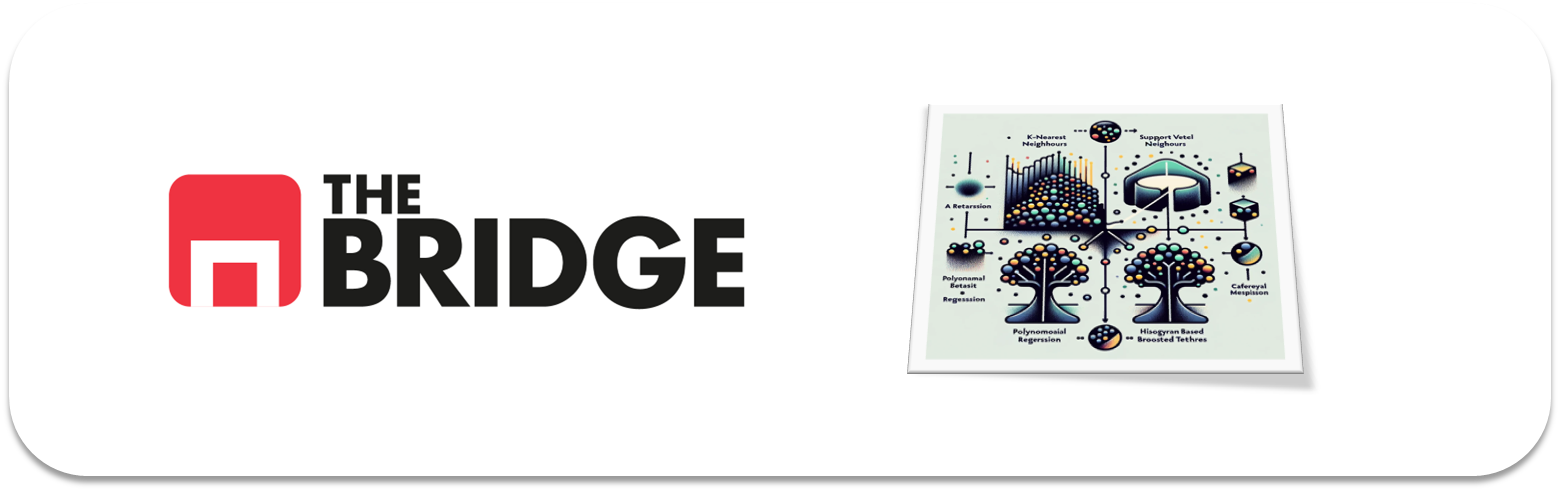

## PRACTICA OBLIGATORIA: **Otros Modelos Supervisados**

* La práctica obligatoria de esta unidad consiste en resolver un modelado de clasificación, incluyendo KNN entre los posibles modelos, y aplicando balanceado. Para ello utilizaremos un dataset que ya hemos empleado en los workout. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

### #1. El problema y los datos

Vamos a volver al dataset con el que vimos la clasificación binaria con regresión logística, "Give me some credit", y nuestro objetivo es crear un modelo que nos permita predicir si una persona va a encontrarse en dificultades financieras en los dos próximos años. El dataset de partida lo puedes en contrar en el directorio data que acompaña al ejercicio. 

### #1.1
Cárgalo y, apoyándote en las herramientas y fuentes que consideres necesarias, haz una descripción textual de sus variables. Luego con ayuda de los datos, haz una clasificación inicial de sus variables en categóricas y numéricas.

In [2]:
df = pd.read_csv("./data/credit_npo.csv")
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,0,0.070709,5656.0,12,1,0,0,0.0
1,0,0.023413,74,0,0.209197,4870.0,9,0,1,0,0.0
2,0,0.000000,43,0,0.080784,5000.0,2,0,0,0,2.0
3,0,0.492754,44,0,0.412735,7333.0,4,0,2,0,3.0
4,0,1.000000,63,0,0.000000,8333.0,3,0,0,0,1.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      12537 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  12537 non-null  float64
 2   age                                   12537 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  12537 non-null  int64  
 4   DebtRatio                             12537 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       12537 non-null  int64  
 7   NumberOfTimes90DaysLate               12537 non-null  int64  
 8   NumberRealEstateLoansOrLines          12537 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  12537 non-null  int64  
 10  NumberOfDependents                    12360 non-null  float64
dtypes: float64(4), 

In [4]:
df["MonthlyIncome"].fillna(df["MonthlyIncome"].median(), inplace = True)
df["NumberOfDependents"].fillna(df["NumberOfDependents"].median(), inplace = True)

1. **SeriousDlqin2yrs:** La persona experimentó una morosidad de 90 días o más
2. **RevolvingUtilizationOfUnsecuredLines:** Saldo total de tarjetas de crédito
3. **age:** Edad del prestatario
4. **NumberOfTime3059DaysPastDueNotWorse:** Número de veces que el prestatario ha estado retrasado en sus pagos entre 30 y 59 días
5. **DebtRatio:** Relación entre ingresos y pagos
6. **MonthlyIncome:** Ingreso mensual real
7. **NumberOfOpenCreditLinesAndLoans:** Número de prestamos
8. **NumberOfTimes90DaysLate:** Número de veces que el prestatario ha estado retrasado en sus pagos más de 90 días
9. **NumberRealEstateLoansOrLines:** Número de prestamos hipotecarios
10. **NumberOfTime60-89DaysPastDueNotWorse:** Número de veces que el prestatario ha estado retrasado en sus pagos entre 60 y 89 días
11. **NumberOfDependents:** Número de personas dependientes de la familia del prestatario

### #1.2
¿Qué tipo de problema estamos tratando? ¿Cuál es la variable target?

In [5]:
target = "SeriousDlqin2yrs"

### #1.3
Pinta la distribución de frecuencias del target y coméntala

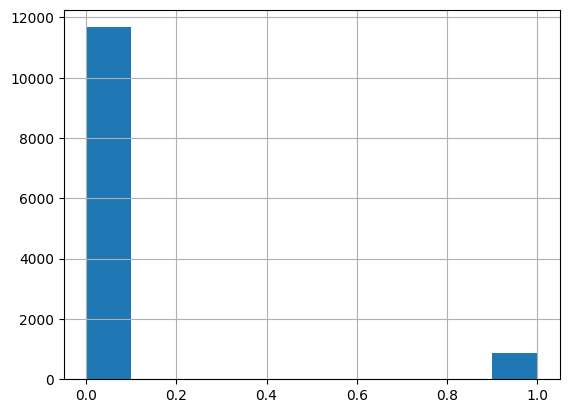

In [6]:
df[target].hist();

### #2 Modelado

Realiza un proceso completo de modelado hasta dar con el mejor modelo de los que hayas escogido (emplea al menos 3, y uno tiene que ser KNN). Aplica las técnicas que creas necesarias para obtener el mejor resultado (suponiendo que este después de hablar con el negocio es el recall medio, para tener un compromiso entre las dos clases). Para comparar modelos emplea validación cruzada antes de optimización y luego ajusta los hiperparámetros del mejor modelo. Evalúa este y haz un pequeño análisis de errores.

In [7]:
# Train/Test

train_set, test_set = train_test_split(df, test_size = 0.2, random_state = 42)

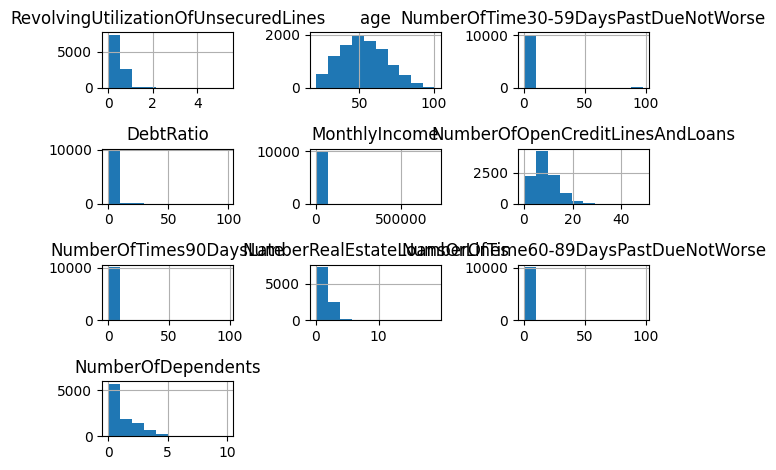

In [8]:
# Selección y tratamiento de "features"

features = [col for col in train_set.columns if col != target]

train_set[features].hist()
plt.tight_layout()

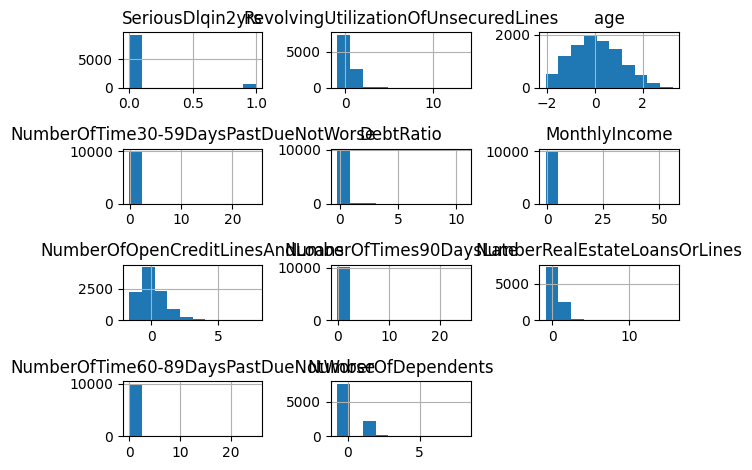

In [9]:
scaler = StandardScaler()
train_set[features] = scaler.fit_transform(train_set[features])
test_set[features] = scaler.transform(test_set[features])

train_set.hist()
plt.tight_layout()

In [10]:
# X, y

X_train = train_set[features]
y_train = train_set[target]

X_test = test_set[features]
y_test = test_set[target]

In [11]:
# KNN

knn_clf = KNeighborsClassifier(n_neighbors = 7)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

In [12]:
print(classification_report(y_train, knn_clf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      9328
           1       0.81      0.15      0.25       701

    accuracy                           0.94     10029
   macro avg       0.88      0.57      0.61     10029
weighted avg       0.93      0.94      0.92     10029



In [13]:
# Comparativa otros modelos

model_names = ["KNN", "Logistic Regression","DecisionTree","Random Forest","XGBoost","LightGBM"]
lr_clf = LogisticRegression(max_iter = 10000)
tree_clf = DecisionTreeClassifier(random_state= 42)
rf_clf = RandomForestClassifier(random_state = 42)
xgb_clf = XGBClassifier(random_state = 42)
lgb_clf = LGBMClassifier(random_state = 42, verbose = -100)

model_set = [knn_clf, lr_clf, tree_clf, rf_clf, xgb_clf, lgb_clf]

In [14]:
metricas_cv = {}
valores = []
for nombre,modelo in zip(model_names, model_set):
    print(modelo)
    if nombre != "Logistic Regression":
        metricas_cv[nombre] = cross_val_score(modelo, X_train, y_train, cv = 3, scoring = "accuracy")
    else:
        metricas_cv[nombre] = cross_val_score(modelo, X_train, y_train, cv = 3, scoring = "accuracy")
    valores.append(np.mean(metricas_cv[nombre]))
ganador = list(metricas_cv.keys())[np.argmax(valores)]

KNeighborsClassifier(n_neighbors=7)
LogisticRegression(max_iter=10000)
DecisionTreeClassifier(random_state=42)
RandomForestClassifier(random_state=42)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)
LGBMClassifier(random_state=42, verbose=-100)


In [15]:
for model_name, valores in metricas_cv.items():
    print(f"Model <{model_name}>, Accuracy_CV: {np.mean(valores)}")
print(f"El ganador es {ganador}")

Model <KNN>, Accuracy_CV: 0.9321966297736565
Model <Logistic Regression>, Accuracy_CV: 0.9303021238408616
Model <DecisionTree>, Accuracy_CV: 0.890716920929305
Model <Random Forest>, Accuracy_CV: 0.933293448997906
Model <XGBoost>, Accuracy_CV: 0.9269119553295443
Model <LightGBM>, Accuracy_CV: 0.9300029913251571
El ganador es Random Forest


In [16]:
# Ajustes y análisis del modelo ganador

params_grid = {
    "n_estimators" : [100, 200, 300],
    "max_depth" : [1, 2, 3],
    "min_samples_leaf": [10, 20, 30],
    "max_features": ["sqrt", "log2", None],
    "max_samples": [0.4, 0.6, 0.8]
}

rf_grid = GridSearchCV(rf_clf,
                       param_grid = params_grid,
                       cv = 3,
                       scoring = "accuracy",
                       n_jobs = -1)

rf_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3],
                         'max_features': ['sqrt', 'log2', None],
                         'max_samples': [0.4, 0.6, 0.8],
                         'min_samples_leaf': [10, 20, 30],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [17]:
rf_grid.best_params_

{'max_depth': 2,
 'max_features': None,
 'max_samples': 0.6,
 'min_samples_leaf': 20,
 'n_estimators': 200}

In [18]:
rf_grid.best_score_

0.9355867982849736

In [19]:
y_pred = rf_grid.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2345
           1       0.58      0.23      0.33       163

    accuracy                           0.94      2508
   macro avg       0.76      0.61      0.65      2508
weighted avg       0.92      0.94      0.93      2508



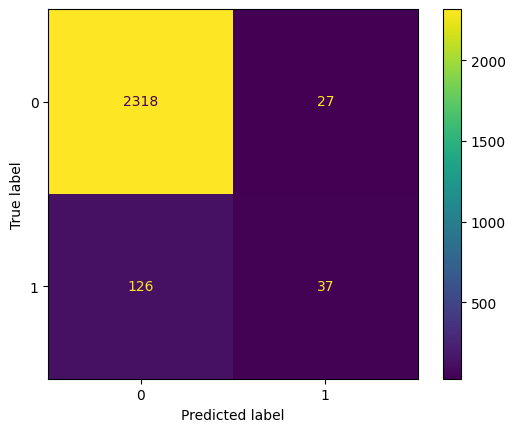

In [20]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);